In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Simple Linear Regression

### One-Dimensional

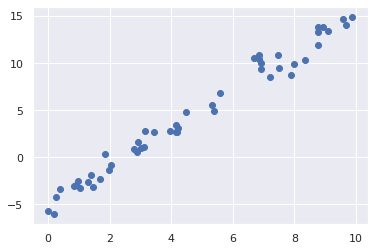

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y)

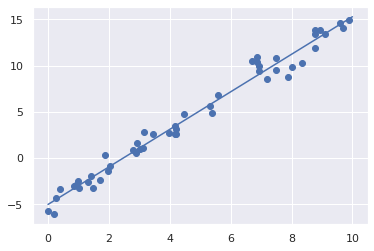

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit)

In [4]:
print("Model slope:", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope: 2.0272088103606953
Model intercept: -4.998577085553204


### 3-Dimensional

In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])
model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.50000000000001
[ 1.5 -2.   1. ]


# Linear Regression on Basis function

### Polynomial Basis Function

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

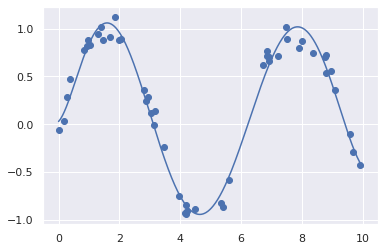

In [8]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit)

### Gauss Basis Function

(0.0, 10.0)

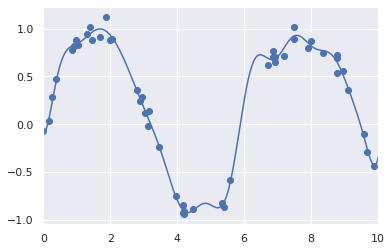

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin


class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Равномерно распределенные Гауссовы признаки
    для одномерных входных данных"""

    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))

    def fit(self, X, y=None):
        # Создаем N центров, распределенных по всему диапазону данных
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self

    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)


gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10)

# Regularization

Used too many basis features we can overfit our model

(-1.5, 1.5)

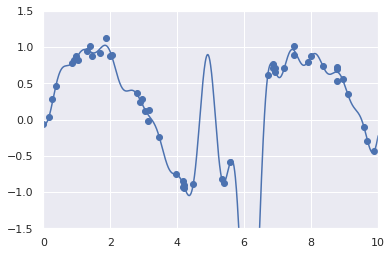

In [11]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)
plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))
plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)

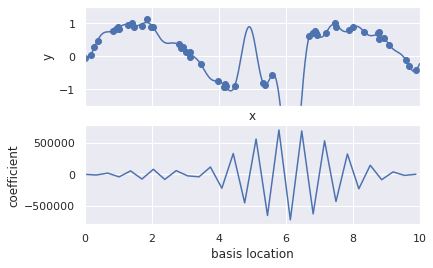

In [12]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    if title:
        ax[0].set_title(title)
    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',  # Базовое местоположение
              ylabel='coefficient',
              # Коэффициент
              xlim=(0, 10))


model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

# Regularization

### Ridge regression or L 2 -regularization (Tikhonov regularization)

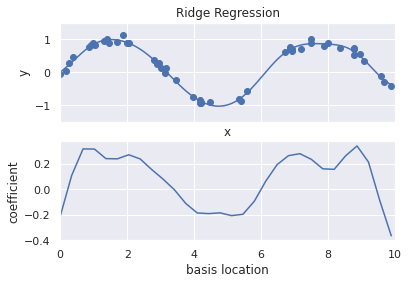

In [13]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')  # Гребневая регрессия

### Lasso Regression

/home/adanik/adanik/myvenv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002135815870488944, tolerance: 0.002065280097246271
  model = cd_fast.enet_coordinate_descent(


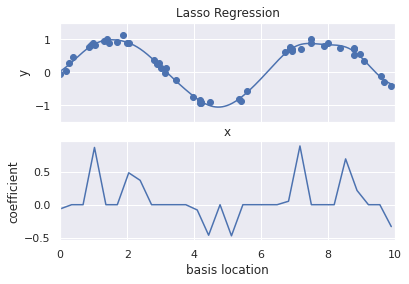

In [14]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')  # Лассо-регуляризация

# Predicting Bicycle Traffic

In [15]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4248k    0 4248k    0     0   865k      0 --:--:--  0:00:04 --:--:--  965k


In [87]:
import pandas as pd
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [73]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [74]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [75]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2020')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

<ipython-input-76-429b25e4bd3e>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


<AxesSubplot:xlabel='Date'>

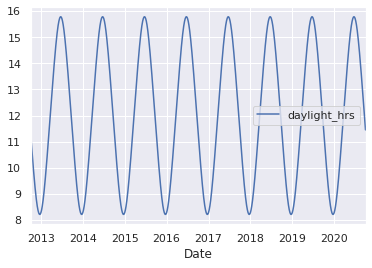

In [76]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Рассчитываем длительность светового дня для заданной даты"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) *
                  np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.


daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()

In [77]:
# Температуры указаны в десятых долях градуса Цельсия;
# преобразуем в градусы
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])
# Осадки указаны в десятых долях миллиметра; преобразуем в дюймы
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [78]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [79]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [80]:
daily=daily.dropna()

In [81]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']  # Всего
model = LinearRegression(fit_intercept=False)
# Зададим параметр fit_intercept = False , поскольку флаги для дней, по сути, 
# выполняют подбор точек пересечения с осями координат по дням
model.fit(X, y)
daily['predicted'] = model.predict(X)

In [82]:
X

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,dry day,Temp (C),annual
Date,,,,,,,,,,,,,
2012-10-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,1.0,13.35,0.000000
2012-10-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,1.0,13.60,0.002740
2012-10-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,1.0,15.30,0.005479
2012-10-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,1.0,15.85,0.008219
2012-10-07,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,1.0,15.85,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.418591,0.019685,0.0,19.45,2.901370
2015-08-29,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.362212,1.279528,0.0,17.75,2.904110
2015-08-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.305611,0.401575,0.0,16.40,2.906849


<AxesSubplot:xlabel='Date'>

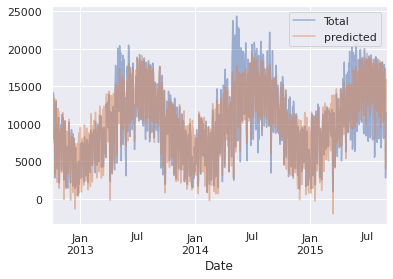

In [83]:
daily[['Total', 'predicted']].plot(alpha=0.5)

In [84]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             2019.531023
Tue             2440.935744
Wed             2370.694566
Thu             1929.432461
Fri              711.921382
Sat            -4413.206842
Sun            -4534.268983
holiday        -4749.605523
daylight_hrs     515.406045
PRCP           -2659.339527
dry day         2190.794369
Temp (C)         260.651164
annual           107.770852
dtype: float64

In [85]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

In [86]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon           2020.0  345.0
Tue           2441.0  333.0
Wed           2371.0  331.0
Thu           1929.0  341.0
Fri            712.0  324.0
Sat          -4413.0  318.0
Sun          -4534.0  332.0
holiday      -4750.0  653.0
daylight_hrs   515.0   36.0
PRCP         -2659.0  249.0
dry day       2191.0  133.0
Temp (C)       261.0   14.0
annual         108.0   71.0


Мы видим, что с каждым дополнительным часом светлого времени суток велосипедистов становится больше на 515 ± 36; рост темпе-ратуры на 1 градус Цельсия стимулирует 261 ± 14 человек взяться за велосипед; сухой день означает в среднем на 2191 ± 133 больше велосипедистов; каждый дюйм осадков означает, что на 2659 ± 249 больше людей оставляют велосипед дома. После учета всех влияний мы получаем умеренный рост ежедневного количества велосипедистов на 108 ± 71 человек в год.